# Parsing the output of AWS Textract

I tried to parse via tesseract. It didn't work. While I was successful in identifying specific cells in the tables the OCR was not refined enough to be useful. I couldn't get a well-fitting product.

## I now try using AWS Textract

Preliminary runs seem to suggest it is more accurate. Still not error-free, but much closer. However, it outputs individual words, not lines or columns or something so there's still some work to be done to transform the sequence of words into a table.



In [222]:
# Import packages and some setup.
import csv
import os
import json

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image


chartDirs = ['chart19', 'chart20', 'chart21', 'chart22', 'chart23']

In [ ]:
# Convert a specific page of the pdf to png.
import pdf2image
def getPngPage(fname) -> Image:
    tmp = pdf2image.convert_from_path(
        fname,
        dpi=600,
        grayscale=True
    )[0]
    tmpData = np.asarray(tmp)
    return Image.fromarray((tmpData > 128).astype(np.uint8)*255)

In [223]:
class BlockTable:

    class Block:
        # Page coordinates are based on the top left corner of the page. Increasing value right and down.
        def __init__(self, text, confidence, boundingBox, padding=None):
            self.text = text
            self.confidence = confidence
            self.boundingBox = boundingBox
            self.padding = padding or [1.0, 1.0]

            
        @property
        def cx(self):
            return (2 * self.boundingBox['Left'] + self.boundingBox['Width']) / 2

        @property
        def cy(self):
            return (2 * self.boundingBox['Top'] + self.boundingBox['Height']) / 2

        @property
        def width(self):
            return self.boundingBox['Width']

        @property
        def height(self):
            return self.boundingBox['Height']

        @property
        def left(self):
            return self.cx - (self.width * self.padding[0]) / 2

        @property
        def right(self):
            return self.cx + (self.width * self.padding[0]) / 2

        @property
        def top(self):
            return self.cy - (self.height * self.padding[1]) / 2

        @property
        def bottom(self):
            return self.cy + (self.height * self.padding[1]) / 2

        def overlapsColumns(self, other):
            return (self.left < other.left and self.right > other.right) or \
                (other.left < self.left and other.right > self.right) or \
                (self.left < other.left and self.right > other.left) or \
                (self.left < other.right and self.right > other.right)
        
        @property
        def asNumber(self):
            if self.text == '(10)':
                return -1
            retStr = ""
            for c in self.text:
                if c in '0123456789':
                    retStr = retStr + c
            if len(retStr):
                return int(retStr)
            return -1

        def __repr__(self, *args, **kwargs):
            return self.text

    def __init__(self, headers, js):
        self.headers = headers
        blocks = filter(lambda blk: blk['BlockType'] == 'WORD', js['Blocks'])
        blocks = list(map(lambda b: BlockTable.Block(b['Text'],
                                                          b['Confidence'],
                                                          b['Geometry']['BoundingBox'],
                                                          [1, 1]), blocks))
        # print([b.text for b in blocks[:40]])
        self.blockHeaders = {}
        for block in blocks:
            if list(map(lambda b: b.text, self.blockHeaders.keys())) == self.headers:
                break
            if block.text in headers and block.cy < 0.25:
                block.padding = [3,1]
                self.blockHeaders.update({block: []})
        for block in blocks:
            for k in self.blockHeaders.keys():
                if k.cy < block.cy and block.overlapsColumns(k):
                    self.blockHeaders[k].append(block)
                    break
        for header, column in self.blockHeaders.items():
            column.sort(key=lambda e: e.cy)
    
    @property
    def numpyArray(self):
        columns = list(map(lambda e: [e[0]] + e[1], self.blockHeaders.items()))
        columns.sort(key=lambda lst: lst[0].cx)
        numRows = max(map(lambda col: len(col) - 1, columns))
        ret = np.ndarray((numRows, len(columns)), dtype=np.int32) * 0 - 1
        for i, col in enumerate(columns):
            for j, cell in enumerate(col):
                if j > 0:
                    ret[j-1,i] = cell.asNumber
        return ret

In [224]:
# Function for getting the table from a singular page.
def getTable(js, colHeaders):
    table = BlockTable(js, colHeaders)
    return table.numpyArray



In [225]:
table19 = getTable(
    ['Year', *[str(i) for i in range(89, 102)]],
    json.load(open('/home/jordan/Immigration/Sources/colonial-1970-migration/chart19/apiResponse.json')))


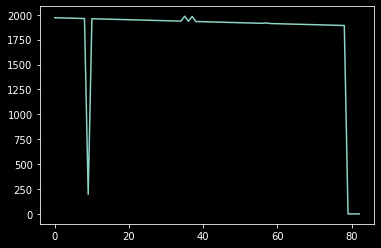

In [226]:
# print(table19.shape)
plt.plot(table19[:,0])

np.savetxt('table19.csv', table19, delimiter=',')
    